# PETITE BSM shower generation example

PETITE is a simple, lightweight, toy Monte Carlo that generates realistic electromagnetic showers. 

Authors: Kevin J. Kelly (Texas A&M), Nikita Blinov (U. Victoria), Ryan Plestid (Caltech), Patrick J. Fox (Fermilab), and Pedro A.M. Machado (Fermilab)

It includes explicit simulation of (we denote nuclei by their electric charge $Z$)

* Bremsstrahlung  $e^\pm Z \rightarrow e^\pm \gamma Z$. 
* Pair production $\gamma Z \rightarrow e^+ e^- Z$. 
* Compton scattering $\gamma e^- \rightarrow  \gamma e^-$
* Pair-annihilation $e^+ e^- \rightarrow \gamma\gamma$ 

and implicit simulation of 

* Multiple Coulomb scattering
* Energy loss by ionization 

${\bf Dependencies}$: numpy, vegas, pickle, cProfile, tqdm, scipy

${\bf Version~ requirements}$: numpy 1.24  ,  python3.xx with xx$\geq$9.

${\bf Directory~structure}$: This notebook assumes that within a PETITE home directory there is folder containing dictionaries, and that within that folder the following files exist 

* $\verb|<PETITE_home_dir>|$/$\verb|<dictionary_dir>|$/Feb13_xSec_Dicts.pkl
* $\verb|<PETITE_home_dir>|$/$\verb|<dictionary_dir>|$/Mar24_xSec_Dicts.pkl
* $\verb|<PETITE_home_dir>|$/$\verb|<dictionary_dir>|$/Mar24_xSec_Dicts_neval.pkl

You can check versions with the code below and adjust if necessary

In [1]:
from platform import python_version
print("Python version: ", python_version())

import numpy
print("Numpy version: ", numpy.__version__)

import os
current_path = os.getcwd()
PETITE_home_dir= current_path.split('examples')[0]

print("PETITE home directory:", PETITE_home_dir)

dictionary_dir = "data/VEGAS_dictionaries/"

Python version:  3.10.11
Numpy version:  1.25.0
PETITE home directory: /Users/kjkelly/Documents/GitHub/PETITE/


### Load in dependencies and set font styles

In [2]:
#from kjkutils import *
from PETITE.dark_shower import *
import pickle as pk
from matplotlib import pyplot as plt
from tqdm import tqdm
import matplotlib

from matplotlib.font_manager import FontProperties
from matplotlib.ticker import FixedLocator, MaxNLocator
import cProfile
profile = cProfile.Profile()
import pstats

font0 = FontProperties()
font = font0.copy()
font.set_size(24)
font.set_family('serif')
labelfont=font0.copy()
labelfont.set_size(20)
labelfont.set_weight('bold')
legfont=font0.copy()
legfont.set_size(18)
legfont.set_weight('bold')


def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)



####  Import two shower objects, one with a graphite target and one with lead. Both track down to minimum energies of 10 MeV

The minimum energy in the shower dictates the run-time. As one attempts to simulate lower-threshold IR physics, the computational cost increases exponentially. The number of low energy particles proliferates and one encounters many compton scatters.  10 MeV allows for reasonable simulation speed. 

Pre-loaded materials are lead and graphite, but other materials can be included straightforwardly running other scripts in the PETITE utilities folder

In [3]:
sGraphite = DarkShower(PETITE_home_dir+dictionary_dir, "graphite", 0.030, 0.030)

In [4]:
print(sGraphite._mV_list)
print(sGraphite._mV)
print(sGraphite._mV_estimator)

[0.003, 0.01, 0.03, 0.1, 0.3, 1.0]
0.03
0.03


In [5]:
sGraphite._loaded_dark_samples['ExactBrem'][10][1]['max_F']

{'graphite': 0.016382356047172152, 'lead': 2.993815796824934}

In [6]:
list(sGraphite.draw_dark_sample(20.0, 50, "ExactBrem"))

/var/folders/8n/m3w03969119_28y6ndzhqp480000gp/T/ipykernel_23386/305639368.py:1: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  list(sGraphite.draw_dark_sample(20.0, 50, "ExactBrem"))


[0.9407667604054284, -7.336650100623586, -8.836220549514143]

In [6]:
p0 = pickle.load(open(PETITE_home_dir+dictionary_dir+"dark_xsecs.pkl", "rb"))[sGraphite._mV_estimator]['ExactBrem']['graphite']

In [7]:
print(sGraphite.GetBSMWeights(-11, 1.0, process="Ann"), sGraphite.GetBSMWeights(-11, 1.0, process="ExactBrem"))

0.049636071852103614 4.068967669779519e-05


Text(0, 0.5, '$\\sigma_{\\rm dark\\ brem.}\\ [\\mathrm{GeV}^{-2}]$')

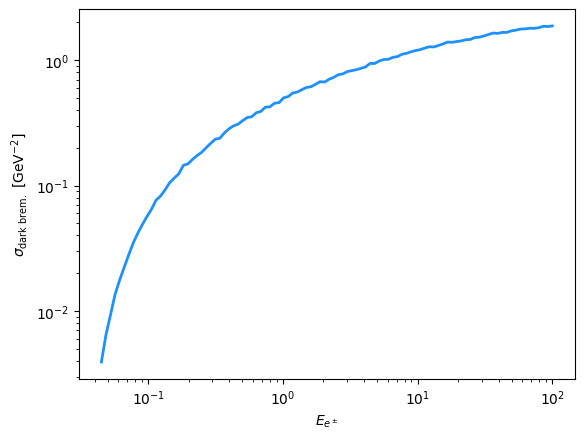

In [8]:
sX, sY = np.transpose(p0)
plt.plot(sX, sY, lw=2, color='dodgerblue')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.gca().set_xlabel(r"$E_{e^\pm}$")
plt.gca().set_ylabel(r"$\sigma_{\rm dark\ brem.}\ [\mathrm{GeV}^{-2}]$")

In [15]:
ntrials = []
xs = []
for k in tqdm(range(100000)):
    s0 = sGraphite.draw_dark_sample(4.55, 70, "ExactBrem", VB=True)
    xs.append([s0[0], s0[1]])
    ntrials.append(s0[-1])

  0%|          | 0/100000 [00:00<?, ?it/s]

/var/folders/8n/m3w03969119_28y6ndzhqp480000gp/T/ipykernel_23386/4006478780.py:4: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  s0 = sGraphite.draw_dark_sample(4.55, 70, "ExactBrem", VB=True)
100%|██████████| 100000/100000 [01:14<00:00, 1351.24it/s]


In [16]:
np.max(ntrials)

652.0

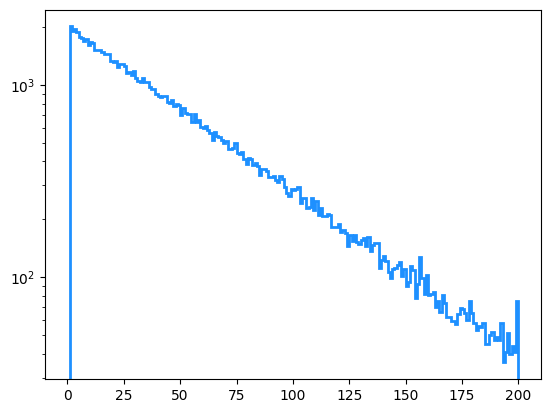

In [17]:
plt.hist(ntrials, bins=np.linspace(0, 200, 201), histtype='step', lw=2, color='dodgerblue')
plt.gca().set_yscale('log')

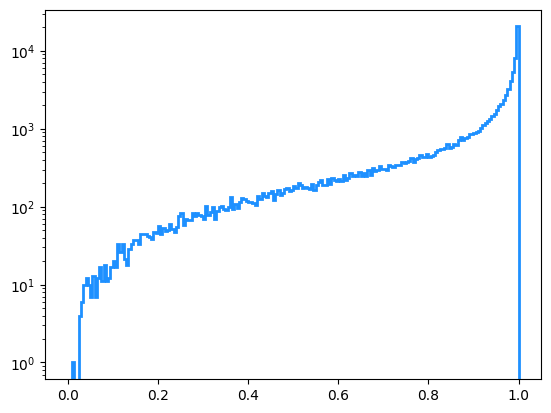

In [18]:
plt.hist(np.transpose(xs)[0], bins=np.linspace(0, 1, 201), histtype='step', lw=2, color='dodgerblue')
plt.gca().set_yscale('log')

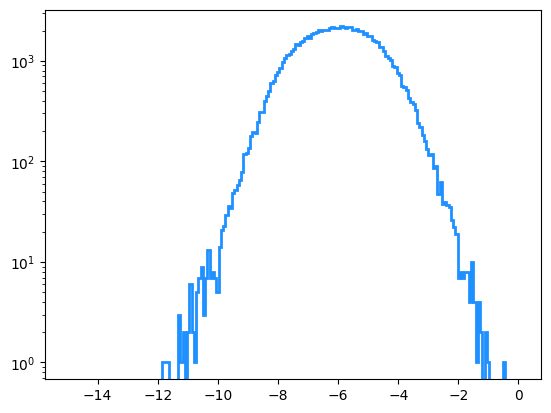

In [19]:
plt.hist(np.transpose(xs)[1], bins=np.linspace(-15,0, 201), histtype='step', lw=2, color='dodgerblue')
plt.gca().set_yscale('log')

In [21]:
sGraphite._mV_estimator

0.03

In [9]:
Energies, Weights = {}, {}
parent_pid_options = [11, -11, 22]
for pr in dark_process_code.keys():
    Energies[pr] = {}
    Weights[pr] = {}
    for pid in parent_pid_options:
        Energies[pr][pid] = []
        Weights[pr][pid] = []

for kk in tqdm(range(1000)):
    p0 = [10, 0, 0, 10]
    r0 = [0, 0, 0]
    pdict = {"PID":22}
    part0 = Particle(p0, r0, pdict)
    s0SM = sGraphite.generate_shower(part0)
    s0BSM = sGraphite.generate_dark_shower(ExDir=list(s0SM));
    for p0 in s0BSM[1]:   
        genprocess = p0.get_ids()["generation_process"]
        parent_pid = p0.get_ids()["parent_PID"]

        Energies[genprocess][parent_pid].append(p0.get_p0()[0])
        Weights[genprocess][parent_pid].append(p0.get_ids()["weight"])

 29%|██▉       | 293/1000 [05:45<13:13,  1.12s/it]

In [23]:
len(s0SM), len(s0BSM[1])

(559, 1)

Text(0.5, 0, '$E_V\\ [\\mathrm{GeV}]$')

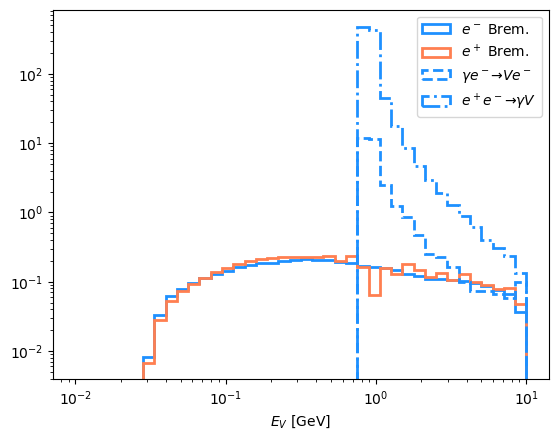

In [19]:
plt.hist(Energies['ExactBrem'][11], weights=Weights['ExactBrem'][11], bins=np.logspace(-2, 1, 41), histtype='step', lw=2, color='dodgerblue', label=r"$e^-\ \mathrm{Brem.}$")
plt.hist(Energies['ExactBrem'][-11], weights=Weights['ExactBrem'][-11], bins=np.logspace(-2, 1, 41), histtype='step', lw=2, color='coral', label=r"$e^+\ \mathrm{Brem.}$")
plt.hist(Energies['Comp'][22], weights=Weights['Comp'][22], bins=np.logspace(-2, 1, 41), histtype='step', lw=2, ls='--', color='dodgerblue', label=r"$\gamma e^- \to V e^-$")
plt.hist(Energies['Ann'][-11], weights=Weights['Ann'][-11], bins=np.logspace(-2, 1, 41), histtype='step', lw=2, ls='-.', color='dodgerblue', label=r"$e^+ e^- \to \gamma V$")
plt.legend(loc='best')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.gca().set_xlabel(r"$E_V\ [\mathrm{GeV}]$")

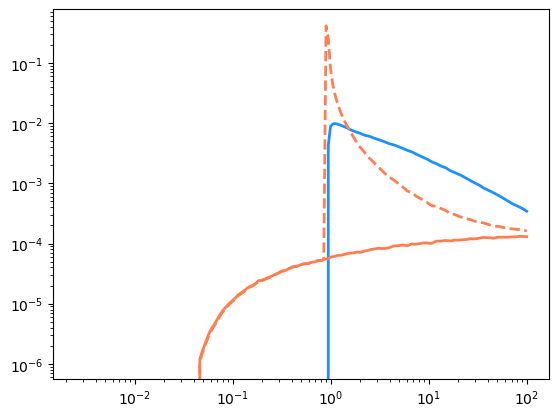

In [22]:
energyvec = np.logspace(-2.6, 2, 201)
plt.plot(energyvec, [sGraphite.GetBSMWeights(22, ee) for ee in energyvec], lw=2, color='dodgerblue')
plt.plot(energyvec, [sGraphite.GetBSMWeights(11, ee) for ee in energyvec], lw=2, color='coral')
plt.plot(energyvec, [sGraphite.GetBSMWeights(-11, ee) for ee in energyvec], lw=2, ls='--', color='coral')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

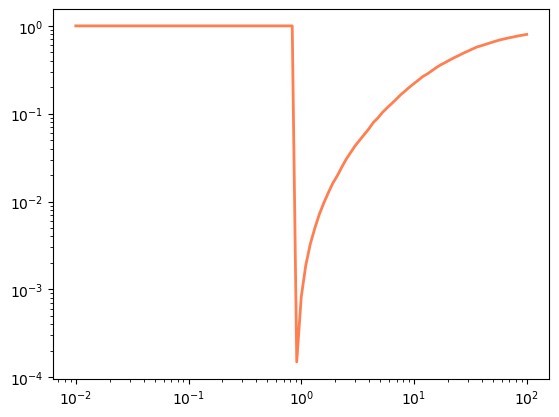

In [23]:
energyvec = np.logspace(-2., 2, 101)
plt.plot(energyvec, [sGraphite.GetPositronDarkBF(ee) for ee in energyvec], lw=2, color='coral')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

In [24]:
len(s0BSM[1])

368

In [25]:
s = np.array(s0BSM[1])
s[np.where(np.array([p0.get_ids()[-2] for p0 in s0BSM[1]]) == 1)[0]]

array([], dtype=object)